# ECS7006 Music Informatics - Lab 5 - Audio Identification

## Introduction

The purpose of this lab session is to provide a starting point for Coursework 2 of Music Informatics, which is on the topic of audio identification covered in week 9.

As before, you are encouraged to familiarise yourselves with python libraries for scientific computing used in the module:
- [Numpy](https://numpy.org/devdocs/user/quickstart.html)
- [Matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html)
- [SciPy](https://docs.scipy.org/doc/scipy/tutorial/)
- [librosa](https://librosa.org/doc/latest/tutorial.html)

In today's lab we will also be using a function from python's [skimage.feature](https://scikit-image.org/docs/stable/api/skimage.feature.html) module. 

## Building constellation maps

For the purposes of today's lab, we will use one 30 sec recording of jazz music from the [GTZAN dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) originally created for music genre classification by George Tzanetakis and Perry Cook, and a 10 sec snippet of the same recording, which has been degraded with added speech and noise:

In [19]:
import os
import IPython.display as ipd

ipd.display(ipd.Audio(os.path.join('classical.00000.wav')))
ipd.display(ipd.Audio(os.path.join('jazz.00005-snippet-10-0.wav')))



From the perspective of an audio identification system, the goal would be to correctly recognise the second (query) recording as being a segment of the first (database) recording.

One such approach for building an audio identification system would be to create a **constellation map** for each of the query and database recordings. As stated in the week 9 lecture, the constellation map is a two-dimensional representation that reduces a complicated spectrogram representation of the signal to a sparse set of coordinates. It is important to note that the magnitudes of the peaks are no longer used: only the time and frequency stamps of the peaks are considered, which introduces a high degree of robustness.

One simple approach (not the only approach by far) for creating a constellation map is shown below. We will use various librosa functions for loading an audio recording and computing its STFT spectrogram, and we will also use a function from python's skimage package for peak picking:

In [2]:
import os
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

def detect_peaks(song_path):
    # Load audio
    y, sr = librosa.load(song_path)
    # Compute STFT spectrogram
    D = np.abs(librosa.stft(y, n_fft=1024, window='hann', win_length=1024, hop_length=512))
    

    
    # Detect peaks from the log-scaled spectrogram.
    # A small constant (1e-10) is added to avoid log(0) issues.
    coordinates = peak_local_max(np.log(D + 1e-10), min_distance=10, threshold_rel=0.05)
    return coordinates

def create_inverted_index(database_folder):
    inverted_index = {}
    # Loop through each audio file in the database folder
    for file in os.listdir(database_folder):
        if file.lower().endswith('.wav'):
            song_path = os.path.join(database_folder, file)
            song_id = file  # use file name as song identifier
            coordinates = detect_peaks(song_path)
            # For each detected peak, update the inverted index
            for coord in coordinates:
                freq, time_idx = coord
                # Create a hash key. Here we use a tuple of (frequency, time index)
                # In a real system you might create a more complex hash (possibly pairing peaks).
                key = (int(freq), int(time_idx))
                if key in inverted_index:
                    inverted_index[key].append((song_id, int(time_idx)))
                else:
                    inverted_index[key] = [(song_id, int(time_idx))]
    return inverted_index

# Define the path to your database recordings folder
database_folder = r'dataset\database_recordings\database_recordings'

# Build the inverted index from the audio database
inverted_index = create_inverted_index(database_folder)

# Print a few keys and their occurrences in the inverted index
for key in list(inverted_index.keys())[:5]:
    print(f"Key: {key}, Occurrences: {inverted_index[key]}")


KeyboardInterrupt: 

In [ ]:
all_hashes

In [11]:
import numpy as np
import librosa
import os
from skimage.feature import peak_local_max

def detect_peaks(song):
    """Loads an audio file and detects peaks in its spectrogram."""
    y, sr = librosa.load(os.path.join(song))
    D = np.abs(librosa.stft(y, n_fft=1024, window='hann', win_length=1024, hop_length=512))
    coordinates = peak_local_max(np.log(D + 1e-10), min_distance=10, threshold_rel=0.025)  # Avoid log(0) issues
    return coordinates, D.shape, D

def analyze_and_visualize(coordinates, spectrogram_shape, D, target_zone_time=50, target_zone_freq=80, fan_out=10):
    """Creates an anchor dictionary with target zones for each anchor point."""
    sorted_coords = coordinates[coordinates[:, 1].argsort()]
    anchor_dict = {}

    for i, anchor in enumerate(sorted_coords):
        min_time = anchor[1] + 1
        max_time = anchor[1] + target_zone_time
        min_freq = max(0, anchor[0] - target_zone_freq)
        max_freq = min(spectrogram_shape[0], anchor[0] + target_zone_freq)

        candidates = [
            point for j, point in enumerate(sorted_coords) if j != i
            and min_time <= point[1] <= max_time and min_freq <= point[0] <= max_freq
        ]
        candidates_sorted = sorted(candidates, key=lambda p: D[int(p[0]), int(p[1])], reverse=True)
        anchor_dict[tuple(anchor)] = candidates_sorted[:fan_out]

    return anchor_dict

def hash_anchors(anchor_dict):
    """Generates hashes from anchor points and their target points."""
    hashes = []
    for anchor, target_points in anchor_dict.items():
        f1, t1 = anchor
        for target in target_points:
            f2, t2 = target
            t = t2 - t1
            hashes.append([f1, f2, t])
    return hashes

# Directory containing all audio files
database_folder = "dataset/database_recordings/database_recordings/"

# List to store hashes for all files
all_hashes = []

# Process each file in the directory
for file in os.listdir(database_folder):
    if file.endswith(".wav"):
        
        file_path = os.path.join(database_folder, file)
        print(f"Processing: {file}")

        # Step 1: Detect peaks
        coordinates, spec_shape, D = detect_peaks(file_path)
        

        # Step 2: Generate anchor dictionary
        anchor_dict = analyze_and_visualize(coordinates, spec_shape, D, target_zone_time=200, target_zone_freq=80, fan_out=10)

        # Step 3: Compute hashes
        file_hashes = hash_anchors(anchor_dict)

        # Step 4: Append to all_hashes
        all_hashes.append(file_hashes)
        



# Plot constellation map
plt.figure(figsize=(10, 5))
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.title('Constellation Map')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')


print(f"Processed {len(all_hashes)} files. Total hash lists created: {len(all_hashes)}")


Processing: classical.00000.wav
Processing: classical.00001.wav
Processing: classical.00002.wav
Processing: classical.00003.wav
Processing: classical.00004.wav
Processing: classical.00005.wav
Processing: classical.00006.wav
Processing: classical.00007.wav
Processing: classical.00008.wav
Processing: classical.00009.wav
Processing: classical.00010.wav
Processing: classical.00011.wav
Processing: classical.00012.wav
Processing: classical.00013.wav
Processing: classical.00014.wav
Processing: classical.00015.wav
Processing: classical.00016.wav
Processing: classical.00017.wav
Processing: classical.00018.wav
Processing: classical.00019.wav
Processing: classical.00020.wav
Processing: classical.00021.wav
Processing: classical.00022.wav
Processing: classical.00023.wav
Processing: classical.00024.wav
Processing: classical.00025.wav
Processing: classical.00026.wav
Processing: classical.00027.wav
Processing: classical.00028.wav
Processing: classical.00029.wav
Processing: classical.00030.wav
Processi

KeyboardInterrupt: 

In [57]:

print(len(hashes))
total_targets = sum(len(target_list) for target_list in anchor_dict.values())
print("Total number of target points:", total_targets)

2523
Total number of target points: 11009


199


Total number of peaks in constellation map: 53
31 ############################################################################
Coordinate: [  44 1733], Energy: 8.427433013916016
Coordinate: [  51 1784], Energy: 1.6838042736053467
Coordinate: [  35 1781], Energy: 1.6004364490509033
Coordinate: [  44 1818], Energy: 1.3671956062316895
Coordinate: [  44 1877], Energy: 1.3015981912612915
Coordinate: [  33 1799], Energy: 1.2064979076385498
Anchor point: (freq=22, time=1729)
Target zone: time=[1730, 1929], freq=[0, 102]
Number of selected points in target zone (fan_out applied): 6


AttributeError: 'tuple' object has no attribute 'items'

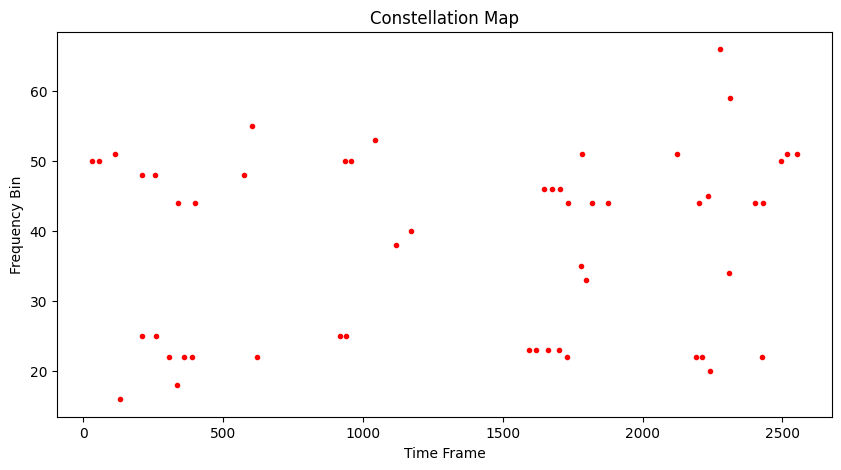

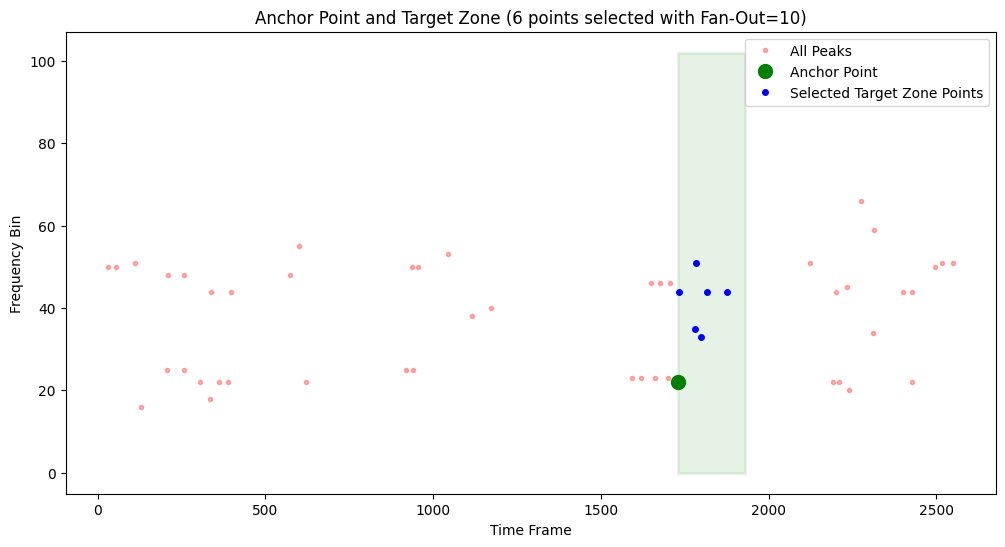

In [13]:
import numpy as np
import librosa
import librosa.display
import os
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from skimage.feature import peak_local_max

def detect_peaks(song, threshold_rel=0.01, n_mels=128):
    """Uses mel spectrogram for better frequency resolution."""
    y, sr = librosa.load(song)
    
    # Use mel spectrogram instead of linear STFT
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=n_mels)
    
    # Find peaks
    coordinates = peak_local_max(np.log(mel_spec + 1e-10), min_distance=15, threshold_rel=threshold_rel)
    
    return coordinates, mel_spec.shape, mel_spec

def hash_anchors(anchor_dict):
    """Generates hashes from anchor points and their target points."""
    hashes = []
    for anchor, target_points in anchor_dict.items():
        f1, t1 = anchor
        for target in target_points:
            f2, t2 = target
            t = t2 - t1
            hashes.append([f1, f2, t])
    return hashes

def analyze_and_visualize(coordinates, spectrogram_shape, D, target_zone_time=50, target_zone_freq=80, fan_out=10):
    # Number of peaks
    num_peaks = len(coordinates)
    print(f"Total number of peaks in constellation map: {num_peaks}")
    
    # Sort coordinates by time
    sorted_coords = coordinates[coordinates[:, 1].argsort()]
    anchor_dict = {}
    
    # Analyze target zones for each anchor using the fan-out heuristic
    for i, anchor in enumerate(sorted_coords):
        # Define target zone boundaries relative to anchor (time is column, frequency is row)
        min_time = anchor[1] + 1
        max_time = anchor[1] + target_zone_time
        min_freq = max(0, anchor[0] - target_zone_freq)
        max_freq = min(spectrogram_shape[0], anchor[0] + target_zone_freq)
        
        # Find candidate points in the target zone (excluding the anchor)
        candidates = [
            point for j, point in enumerate(sorted_coords) if j != i
            and min_time <= point[1] <= max_time and min_freq <= point[0] <= max_freq
        ]
        # Sort candidates by their amplitude (using the original spectrogram D)
        candidates_sorted = sorted(candidates, key=lambda p: D[int(p[0]), int(p[1])], reverse=True)
        # Only consider up to 'fan_out' points from the target zone
        selected = candidates_sorted[:fan_out]
        anchor_dict[tuple(anchor)] = selected
    


    hashes = []

    for anchor, target_points in anchor_dict.items():
        f1, t1 = anchor  # Anchor's frequency and time
        for target in target_points:
            f2, t2 = target  # Target point's frequency and time
            t = t2 - t1  # Time difference
            hashes.append([f1, f2, t])  # Append hash

    
    """
    # Compute statistics
    avg_points = np.mean(points_in_target_zones)
    max_points = np.max(points_in_target_zones)
    min_points = np.min(points_in_target_zones)
    
    print(f"Target zone size: {target_zone_time} frames, ±{target_zone_freq} bins")
    print(f"Average points in target zone (after applying fan_out of {fan_out}): {avg_points:.2f}")
    print(f"Maximum points in target zone: {max_points}")
    print(f"Minimum points in target zone: {min_points}")
    
    # Plot histogram of selected points per target zone
    plt.figure(figsize=(10, 5))
    plt.hist(points_in_target_zones, bins=20)
    plt.title('Histogram of Points in Target Zones (After Fan-Out)')
    plt.xlabel('Number of Points')
    plt.ylabel('Frequency')
    """
    # For visualization, select a random anchor and apply the same heuristic
    valid_anchors = sorted_coords[:-target_zone_time] if len(sorted_coords) > target_zone_time else sorted_coords
    if len(valid_anchors) == 0:
        print("Not enough points for a valid anchor with target zone")
        return
    
    random_index = random.randint(0, len(valid_anchors) - 1)
    #random_index=55
    anchor = valid_anchors[random_index]
    print(random_index,'############################################################################')
    
    # Define target zone boundaries for visualization
    min_time = anchor[1] + 1
    max_time = anchor[1] + target_zone_time
    min_freq = max(0, anchor[0] - target_zone_freq)
    max_freq = min(spectrogram_shape[0], anchor[0] + target_zone_freq)
    
    # Find candidate points in the target zone (excluding the anchor)
    candidates = [
        point for point in sorted_coords
        if not np.array_equal(point, anchor) and min_time <= point[1] <= max_time and min_freq <= point[0] <= max_freq
    ]
    # Sort and select up to 'fan_out' points based on amplitude
    candidates_sorted = sorted(candidates, key=lambda p: D[int(p[0]), int(p[1])], reverse=True)
    selected_points = np.array(candidates_sorted[:fan_out])

    # Print the energy and coordinates for each candidate in candidates_sorted
    for point in candidates_sorted:
        energy = D[int(point[0]), int(point[1])]
        print(f"Coordinate: {point}, Energy: {energy}")

    
    # Plot constellation map with target zone for visualization
    plt.figure(figsize=(12, 6))
    plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.', alpha=0.3, label='All Peaks')
    plt.plot(anchor[1], anchor[0], 'go', markersize=10, label='Anchor Point')
    if selected_points.size:
        plt.plot(selected_points[:, 1], selected_points[:, 0], 'b.', markersize=8, label='Selected Target Zone Points')
    
    target_zone_rect = Rectangle((min_time, min_freq), max_time - min_time, max_freq - min_freq,
                                 linewidth=2, edgecolor='g', facecolor='g', alpha=0.1)
    plt.gca().add_patch(target_zone_rect)
    
    plt.title(f'Anchor Point and Target Zone ({len(selected_points)} points selected with Fan-Out={fan_out})')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency Bin')
    plt.legend()
    
    print(f"Anchor point: (freq={anchor[0]}, time={anchor[1]})")
    print(f"Target zone: time=[{min_time}, {max_time}], freq=[{min_freq}, {max_freq}]")
    print(f"Number of selected points in target zone (fan_out applied): {len(selected_points)}")
    
    return  anchor, selected_points
    

# Use the functions
file_path = 'dataset/database_recordings/database_recordings/classical.00003.wav'
coordinates, spec_shape, D = detect_peaks(file_path)

# Plot constellation map
plt.figure(figsize=(10, 5))
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.title('Constellation Map')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')

# Analyze and visualize the constellation map with fan-out heuristic
anchor_dict = analyze_and_visualize(coordinates, spec_shape, D,
                                                                 target_zone_time=200,
                                                                 target_zone_freq=80,
                                                                 fan_out=10)

hashes = hash_anchors(anchor_dict)
print(hashes[:10])

# Display all plots
#plt.tight_layout()
#plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\q'
<>:8: SyntaxWarning: invalid escape sequence '\q'
C:\Users\spyke\AppData\Local\Temp\ipykernel_25672\3149130738.py:8: SyntaxWarning: invalid escape sequence '\q'
  y, sr = librosa.load(os.path.join('dataset\query_recordings\query_recordings\classical.00003-snippet-10-10.wav'))
C:\Users\spyke\AppData\Local\Temp\ipykernel_25672\3149130738.py:13: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='cqt_note', x_axis='time',sr=sr)


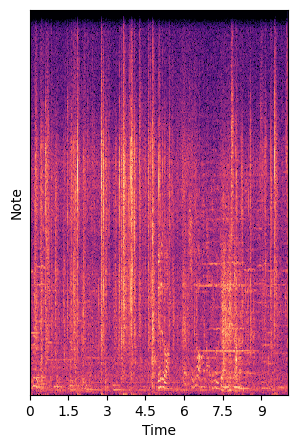

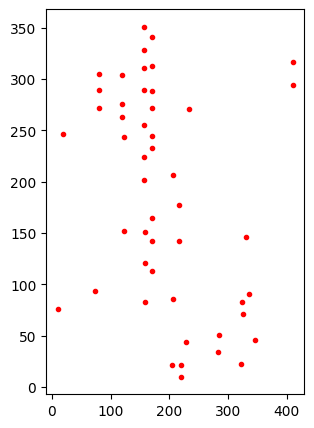

In [3]:
# Load audio
import os
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
y, sr = librosa.load(os.path.join('dataset\query_recordings\query_recordings\classical.00003-snippet-10-10.wav'))

# Compute and plot STFT spectrogram
D = np.abs(librosa.stft(y,n_fft=1024,window='hann',win_length=1024,hop_length=512))
plt.figure(figsize=(10/3, 5))
librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='cqt_note', x_axis='time',sr=sr)

# Detect peaks from STFT spectrogram and plot constellation map
coordinates = peak_local_max(np.log(D), min_distance=10,threshold_rel=0.05)
plt.figure(figsize=(10/3, 5))
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

In [4]:
sr

22050

The query recording includes the first 10 seconds of the 30 second database recording. By visually inspecting the database and query constellation maps, we see that there are differences between the peak content of the two recordings; although there are some commonalities too, and only a few matched peaks might be sufficient to produce a correct identification.

There are many other options for building a constellation map. For example, you could try to implement a 2D peak picking algorithm following the process described in slide 14 of the week 9 slides. There are other python packages you can explore, for example the scipy.ndimage python package which has a maximum_filter() function that can create a maximum filter using a 2D neighbourhood.

## Task

As part of today's lab: 
* Investigate different peak picking options for creating constellation maps, and use the two lab recordings to plot the derived constellation maps. 
* Experiment with different time-frequency representations beyond the STFT, e.g. you can use the CQT spectrogram or mel spectrogram as alternatives.
* Explore different parameters for your time-frequency representations. For example for the STFT, you can experiment with different window length and hop size parameters.
* Explore different parameters for defining your peak picking neighbourhood.

An investigation of how audio identification performance can be affected by different input time-frequency representations and peak selection algorithms would be an asset for your coursework submission - possibly more than obtaining good audio identification performance using a fixed set of parameters!